# PET Signal for Labelling
A script to show how to use the PET Signal for labeling tumors.

In [99]:
import os
import h5py
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

# utility functions
make_proj = lambda x: np.sum(x,1)[::-1]
make_mip = lambda x: np.max(x,1)[::-1]

# Loading and Displaying PET and CT
Here we load the PET, CT and Label data from a _single_ patient and show the projection image for CT, the Maximum Intensity Projection (MIP) view for the PET data and the label data.

In [109]:
patient_index = 2
with h5py.File(os.path.join('..', 'input', 'lab_petct_vox_5.00mm.h5'), 'r') as p_data:
    print('Available keys', list(p_data.keys()))
    id_list = list(p_data['ct_data'].keys())
    ct_image = p_data['ct_data'][id_list[patient_index]].value
    pet_image = p_data['pet_data'][id_list[patient_index]].value
    label_image = p_data['label_data'][id_list[patient_index]].value
    # ask kevin why label_image as below
    #label_image = (p_data['label_data'][id_list[0]].value>0).astype(np.uint8)

Available keys ['ct_data', 'label_data', 'pet_data']


### Projection
Show the projection of the images. This means show a 2D view of the 3D image data.

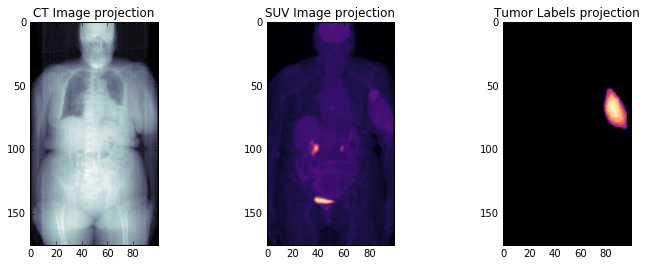

In [110]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 4))
ct_proj = make_proj(ct_image)
suv_max = make_mip(pet_image)
lab_proj = make_proj(label_image)

ax1.set_title('CT Image projection')
ax1.imshow(ct_proj, cmap = 'bone')

ax2.set_title('SUV Image projection')
ax2.imshow(np.sqrt(suv_max), cmap = 'magma')

ax3.set_title('Tumor Labels projection')
ax3.imshow(lab_proj, cmap = 'magma')

## PET Histogram 

Max PET value 58.0361409785


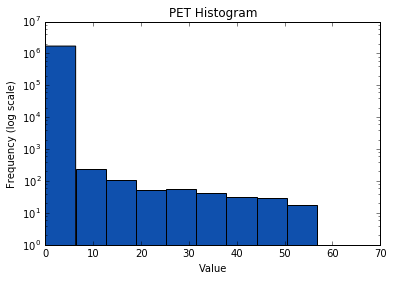

In [111]:
pet_max_value = np.max(pet_image)
print('Max PET value', pet_max_value)
plt.hist(pet_image.ravel(), bins=10, log=True, range=(0, pet_max_value + (pet_max_value//10)), color='#0f50ad')
plt.title('PET Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.show()

## Label Histogram

Max Label value: 2


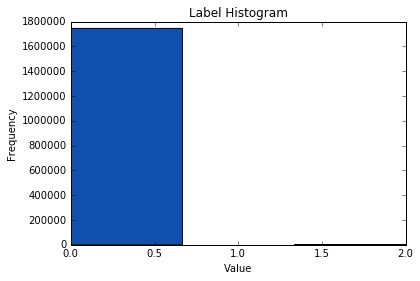

In [112]:
label_max_value = np.max(label_image)
print('Max Label value:', label_max_value)
plt.hist(label_image.ravel(), bins=3, color='#0f50ad')
plt.title('Label Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## Full 3D Superpixels
Here we make full 3D superpixels for PETCT and show a simple rendering of them

In [113]:
pet_weight = 1.0 # how strongly to weight the pet_signal (1.0 is the same as CT)
# based on experience how a radiologist is using the PET window
pet_window = 5
petct_vol = np.stack([np.stack([(ct_slice+1024).clip(0,2048)/2048, 
                                 pet_weight*(suv_slice).clip(0, pet_window)/pet_window], -1) 
                      for ct_slice, suv_slice in zip(ct_image, pet_image)], 0)

In [114]:
%%time
petct_segs = slic(petct_vol, 
                  n_segments = 100,
                  compactness = 1,
                  multichannel = True)

CPU times: user 2.6 s, sys: 83.2 ms, total: 2.68 s
Wall time: 2.72 s


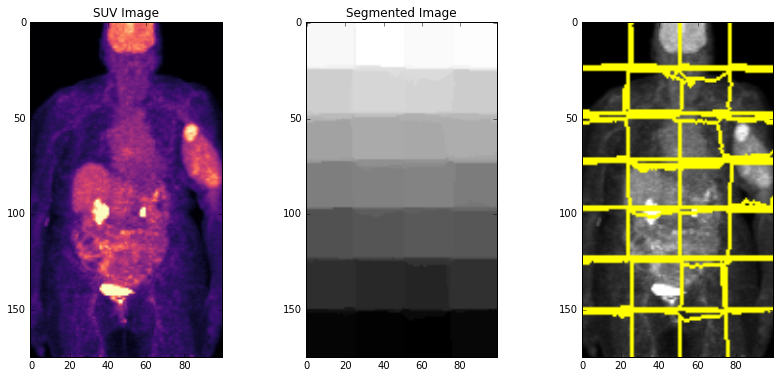

In [115]:
petct_max_segs = make_mip(petct_segs)
ct_proj = make_proj(petct_vol[:,:,:,0])
suv_mip = make_mip(petct_vol[:,:,:,1])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))
ax1.imshow(suv_mip, cmap='magma')
ax1.set_title('SUV Image')
ax2.imshow(petct_max_segs, cmap='gray')
ax2.set_title('Segmented Image')
ax3.imshow(mark_boundaries(suv_mip, petct_max_segs))

## Compare Segments to Labels

We look at each superpixel and see how many different labels are inside it. We want each superpixel to be an 'atomic' unit of the image.

In [116]:
# Count label pixels
unique_labels = np.unique(label_image)
for i in unique_labels:
    u,c = np.unique(label_image[label_image == i], return_counts=True)
    print('label', i, 'pixel count:\t', c[0])

label 0 pixel count:	 1745043
label 1 pixel count:	 3
label 2 pixel count:	 4954


In [117]:
print('Distinct values in CT:\t', '{:,}'.format(len(np.unique(ct_image))))
print('Distinct values in PET:\t','{:,}'.format(len(np.unique(pet_image))))
print('Distinct values in Label:\t', len(np.unique(label_image)))

Distinct values in CT:	 1,133,552
Distinct values in PET:	 1,749,861
Distinct values in Label:	 3


In [118]:
for idx in np.unique(petct_segs):
    cur_region_mask = (petct_segs == idx)
    labels_in_region = label_image[cur_region_mask]
    labeled_region_inside = np.unique(labels_in_region)
    if len(labeled_region_inside) > 1:
        print(labeled_region_inside)
        print('\nSuperpixel id', idx, 'regions', len(labeled_region_inside))
        print(pd.value_counts(labels_in_region))
        print('Missclassified Pixels:', np.sum(pd.value_counts(labels_in_region)[1:].values))

[0 1 2]

Superpixel id 60 regions 3
0    12662
2     2742
1        2
dtype: int64
Missclassified Pixels: 2744
[0 1 2]

Superpixel id 79 regions 3
0    14460
2     2212
1        1
dtype: int64
Missclassified Pixels: 2213


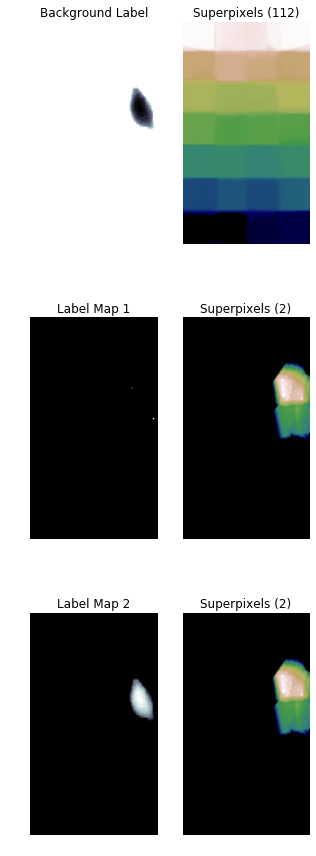

In [119]:
nz_labels = [i for i in np.unique(label_image) if i>=0]
fig, m_axs = plt.subplots(len(nz_labels), 2, figsize = (5, 15))
for (ax1, ax2), i_label in zip(m_axs, nz_labels):
    out_sp = np.zeros_like(petct_segs)
    cur_label_mask = label_image == i_label
    labels_in_region = petct_segs[cur_label_mask]
    
    superpixels_in_region = np.unique(labels_in_region)
    for i, sp_idx in enumerate(superpixels_in_region):
        out_sp[petct_segs == sp_idx] = i+1
    
    ax1.imshow(make_proj(cur_label_mask), cmap = 'bone')
    ax1.set_title('Label Map {}'.format(i_label) if i_label>0 else 'Background Label')
    ax1.axis('off')
    
    ax2.imshow(make_proj(out_sp), cmap = 'gist_earth')
    ax2.set_title('Superpixels ({})'.format(len(superpixels_in_region)))
    ax2.axis('off')

## Show the superpixels for each label
Here we can show which superpixels are inside each label.

In [120]:
for idx in np.unique(label_image):
    cur_region_mask = label_image == idx
    labels_in_region = petct_segs[cur_region_mask]
    labeled_regions_inside = np.unique(labels_in_region)
    print('Label id:', idx, 'superpixels inside', len(labeled_regions_inside))

Label id: 0 superpixels inside 112
Label id: 1 superpixels inside 2
Label id: 2 superpixels inside 2


# Optimize Superpixel Size

In [125]:
def label_score(gt_labels, sp_segs):
    # type: (np.ndarray, np.ndarray) -> float
    """
    Score how well the superpixels match to the ground truth labels. 
    Here we use a simple penalty of number of pixels misclassified
    :param gt_labels: the ground truth labels (from an annotation tool)
    :param sp_segs: the superpixel segmentation
    :return: the score (lower is better)
    """
    out_score = 0
    for idx in np.unique(sp_segs):
        cur_region_mask = sp_segs == idx
        labels_in_region = gt_labels[cur_region_mask]
        if np.sum(labels_in_region) > 0:
            out_score += np.sum(pd.value_counts(labels_in_region)[1:].values)
    return out_score

print('Label Score', label_score(label_image, petct_segs))

Label Score 4957


In [142]:
# Make new superpixels
def make_superpixel(pet_weight = 1.0, # how strongly to weight the pet_signal (1.0 is the same as CT)
                    n_segments = 1000, # number of segments
                    compactness = 1): # how compact the segments are
    
    t_petct_vol = np.stack([np.stack([(ct_slice+1024).clip(0,2048)/2048, 
                            pet_weight*(suv_slice).clip(0,5)/5.0
                           ],-1) for ct_slice, suv_slice in zip(ct_image, pet_image)],0)
    petct_segs = slic(t_petct_vol, 
                      n_segments=n_segments, 
                      compactness=compactness,
                      multichannel=True)
    return petct_segs

def make_and_score(*args, **kwargs):
    n_segs = make_superpixel(*args, **kwargs)
    return label_score(label_image, n_segs)

def f_make(n):
    print('calling f_make with:', n)
    return make_and_score(n_segments=int(n*1000))

#print('Misclassified Pixels', make_and_score(n_segments = 100))

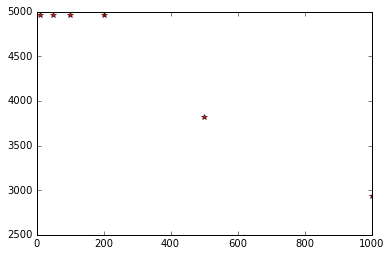

In [126]:
# test different values for n_segments to see how the performance changes
n_segments = [10, 50, 100, 200, 500, 1000]
n_score = [make_and_score(n_segments = c_seg) for c_seg in n_segments]
plt.plot(n_segments, n_score, 'r*')
plt.show()

In [143]:
# Optimize the values
from scipy.optimize import fmin

fmin(f_make, x0=[1], full_output=True, disp=True)

calling f_make with: [ 1.]
calling f_make with: [ 1.05]
calling f_make with: [ 1.1]
calling f_make with: [ 1.075]
calling f_make with: [ 1.025]
calling f_make with: [ 1.0625]
calling f_make with: [ 1.0625]
calling f_make with: [ 1.0375]
calling f_make with: [ 1.05625]
calling f_make with: [ 1.05625]
calling f_make with: [ 1.04375]
calling f_make with: [ 1.053125]
calling f_make with: [ 1.053125]
calling f_make with: [ 1.046875]
calling f_make with: [ 1.0515625]
calling f_make with: [ 1.0515625]
calling f_make with: [ 1.0484375]
calling f_make with: [ 1.05078125]
calling f_make with: [ 1.05078125]
calling f_make with: [ 1.04921875]
calling f_make with: [ 1.05039062]
calling f_make with: [ 1.05039062]
calling f_make with: [ 1.04960938]
calling f_make with: [ 1.05019531]
calling f_make with: [ 1.05019531]
calling f_make with: [ 1.04980469]
calling f_make with: [ 1.05009766]
calling f_make with: [ 1.05009766]
Optimization terminated successfully.
         Current function value: 2506.00000

(array([ 1.05]), 2506.0, 10, 28, 0)